In [1]:
!pip install gcm-filters -q

# Dask start

In [3]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:39761")
client

<Client: 'tcp://127.0.0.1:39761' processes=4 threads=8, memory=29.40 GiB>

# Import

In [4]:
#import s3fs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
import gsw
import gcm_filters
from xhistogram.xarray import histogram
import eos_module
from dask import compute
from dask.diagnostics import ProgressBar
from dask import delayed
import pandas as pd
import cartopy.crs as ccrs
from scipy.stats import kurtosis, skew, describe
from scipy import ndimage
from numpy.polynomial import polynomial as P
import xrft
#import xrft_module
import xesmf as xe

In [5]:
# import importlib
# importlib.reload(xrft)

# Plotting params

In [6]:
#%matplotlib widget
%matplotlib inline

In [7]:
line_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4']

In [8]:
cmaps_list = ['Blues', 'Oranges', 'Greens', 'Reds']

# Load data

Choose cases

In [9]:
data=[dict() for i in range(6)]

In [10]:
data[0] = dict({'region' : '1', 'season' : 'fma', 'label' : 'GULFSTR wint'})
data[1] = dict({'region' : '1', 'season' : 'aso', 'label' : 'GULFSTR sum'})
data[2] = dict({'region' : '2', 'season' : 'fma', 'label' : 'AÇORES wint'})
data[3] = dict({'region' : '2', 'season' : 'aso', 'label' : 'AÇORES sum'})
data[4] = dict({'region' : '3', 'season' : 'fma', 'label' : 'WESTMED wint'})
data[5] = dict({'region' : '3', 'season' : 'aso', 'label' : 'WESTMED sum'})

## eNATL60

In [12]:
from validate_catalog import all_params
params_dict, cat = all_params()

In [13]:
x_slice = slice(0,-1)
y_slice = slice(0,-1)

data_slice = dict(time_counter=slice(0,-1,250),y=y_slice,x=x_slice) 
coord_slice = dict(y=y_slice,x=x_slice)

In [14]:
nb_of_time_chunks = 4

In [16]:
%%time
for i in range(len(data)) :
    #current_set = xr.open_mfdataset('/Users/ana/data/eNATL60_extractions/region'+data[i]['region']+'_'+data[i]['season']+'.nc', parallel=True).chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}).\
    current_set = cat.eNATL60(region=data[i]['region'],datatype='surface_hourly', season=data[i]['season']).to_dask().\
    drop(['fmask','qt_oce', 'somecrty','sometauy','sossheig','sowaflup','sozocrtx','sozotaux','umask','vmask'],errors='ignore')
    current_set = current_set.chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})
    current_set.coords['tmask'] = current_set.tmask.astype(np.float32)
    #current_set = current_set.resample({'time_counter' : resampling_avg_period}, closed='right', label='right').mean()
    current_set = current_set.isel(data_slice)
    current_set.load()
    current_set = current_set.chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})
    current_set['x'] = np.arange(len(current_set['x']))
    current_set['y'] = np.arange(len(current_set['y']))
    data[i]['HR'] = current_set

CPU times: user 2.72 s, sys: 467 ms, total: 3.18 s
Wall time: 1min 24s


## eORCA025

In [51]:
for i in range(len(data)) :
    data[i]['LR'] = xr.open_mfdataset("Data/eORCA025/region"+data[i]['region']+"_"+data[i]['season']+".nc").\
    rename(nav_lat='lat', nav_lon='lon')
    data[i]['LR'] = data[i]['LR'].drop(['time_centered_bounds', 'time_counter_bounds', 'sossheig', 'gradx_temp', 'grady_temp', 'gradx_sal', 'grady_sal',\
                                       'grad_temp', 'grad_sal'])

In [52]:
data[i]['LR']

<xarray.Dataset>
Dimensions:        (time_counter: 56, x: 41, y: 56)
Coordinates:
    lat            (y, x) float32 dask.array<chunksize=(56, 41), meta=np.ndarray>
    lon            (y, x) float32 dask.array<chunksize=(56, 41), meta=np.ndarray>
    time_centered  (time_counter) datetime64[ns] dask.array<chunksize=(56,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 2015-08-01T00:30:00 ... 2015...
    e1t            (y, x) float64 dask.array<chunksize=(56, 41), meta=np.ndarray>
    e2t            (y, x) float64 dask.array<chunksize=(56, 41), meta=np.ndarray>
  * x              (x) int64 0 1 2 3 4 5 6 7 8 9 ... 32 33 34 35 36 37 38 39 40
  * y              (y) int64 0 1 2 3 4 5 6 7 8 9 ... 47 48 49 50 51 52 53 54 55
    tmask          (y, x) float64 dask.array<chunksize=(56, 41), meta=np.ndarray>
Data variables:
    sosstsst       (time_counter, y, x) float32 dask.array<chunksize=(56, 56, 41), meta=np.ndarray>
    sosaline       (time_counter, y, x) float32 dask.array<chunksize=(56, 56, 41), meta=np.ndarray>
Attributes:
    description:       ocean T grid variables
    title:             ocean T grid variables
    Conventions:       CF-1.6
    uuid:              52d391e0-7850-4a5d-b56c-b43fca3a215f
    start_date:        19580101
    output_frequency:  1h
    CONFIG:            eORCA025.L75
    CASE:              IMHOTEP.S
    history:           Mon Aug  9 06:33:45 2021: ncrcat eORCA025.L75-IMHOTEP....
    NCO:               netCDF Operators version 4.9.3 (Homepage = http://nco....

## Plot snapshots

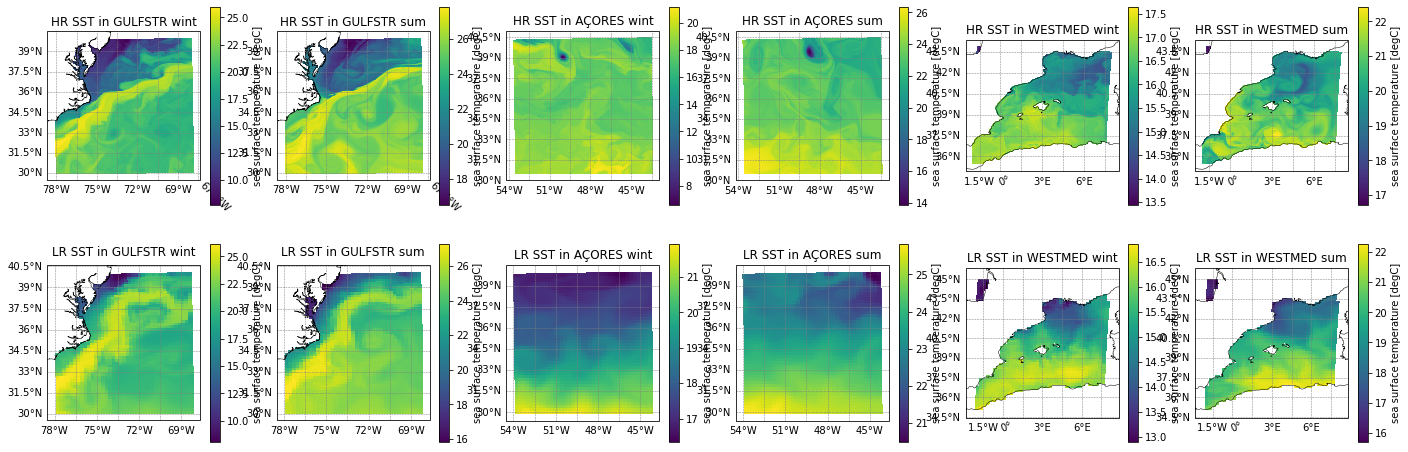

In [19]:
fig, axis = plt.subplots(ncols=len(data), nrows=2, figsize=(24,8), subplot_kw={'projection': ccrs.PlateCarree()})
for col in range(len(data)) :
    for row, dataSetKey in enumerate(['HR', 'LR']) :
        data[col][dataSetKey].isel(time_counter=-1).sosstsst[coord_slice].plot(x='lon', y='lat', ax=axis[row,col])
        axis[row,col].set(title=dataSetKey + ' SST in ' + data[col]['label'])

for ax in axis.flatten() :
    ax.coastlines(color='k', lw=0.5)
    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, color='grey', linestyle='dashed', linewidth=0.5)
    gl.top_labels = False; gl.right_labels = False

# Density

Compute conservative temperature and density anomaly $\sigma_0$ with the use of `gsw` library:

In [120]:
%%time
for i in range(len(data)) :
    for dataKey in ['LR'] :
        data[i][dataKey]['CT'] = xr.apply_ufunc(gsw.conversions.CT_from_pt, data[i][dataKey]['sosaline'], data[i][dataKey]['sosstsst'], dask='parallelized').compute()
        data[i][dataKey]['sigma0_true'] = xr.apply_ufunc(gsw.density.sigma0, data[i][dataKey]['sosaline'], data[i][dataKey]['CT'], dask='parallelized').compute()
        data[i][dataKey]['CT_sqr'] = data[i][dataKey]['CT']**2

CPU times: user 263 ms, sys: 29 ms, total: 292 ms
Wall time: 1.23 s


# Filters

## Routines

In [121]:
def downsample(data, window_size, area_2d, wet_mask) :
    area_masked = area_2d*wet_mask
    data_weighted = area_masked*data
    data_weighted_sums = data_weighted.coarsen(x=window_size, y=window_size, boundary='trim', \
                                           coord_func={'x':'mean', 'y':'mean', 'lat':'mean', 'lon':'mean'}).sum(skipna=True)
    area_window_sums = area_masked.coarsen(x=window_size, y=window_size, boundary='trim').sum(skipna=True)
    result = data_weighted_sums/area_window_sums
    result['x'] = np.arange(len(result['x']))
    result['y'] = np.arange(len(result['y']))
    
    # coarsened coordinates:
    new_e1t = data['e1t'].coarsen(x=window_size,boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).mean(skipna=True).coarsen(y=window_size, boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).sum(skipna=False).\
drop(['depth', 'e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'],errors='ignore')
    new_e2t = data['e2t'].coarsen(x=window_size,boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).mean(skipna=True).coarsen(y=window_size, boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).sum(skipna=False).\
drop(['depth', 'e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'],errors='ignore')
    result['e1t'] = (['y','x'], new_e1t.values) 
    result['e2t'] = (['y','x'], new_e2t.values) 
    
    # binarize and erode the mask (to remove isolated pixels)
    #threshold = 0.9
    #new_wetmask = ndimage.binary_erosion(np.where((result['tmask'] > threshold), 1.0, 0.0))
    #result['tmask'] = (['y','x'], new_wetmask.astype(np.float32))
    # apply new mask to data
    #result = result.where(result.tmask>0)
    return result

In [122]:
def apply_filter_downsample(dataHR, filter_coef, coarse_window_size) :
    wet_mask = xr.DataArray(dataHR.tmask, dims=['y','x'])
    area = xr.DataArray((dataHR.e1t * dataHR.e2t), dims=['y','x'])
    if (filter_coef > 0) :
        # Filtering with a fixed factor
        dxw = xr.DataArray(dataHR.e1u, dims=['y','x']) # x-spacing centered at western cell edge
        dyw = xr.DataArray(dataHR.e2u, dims=['y','x']) # y-spacing centered at western cell edge
        dxs = xr.DataArray(dataHR.e1v, dims=['y','x']) # x-spacing centered at southern cell edge
        dys = xr.DataArray(dataHR.e2v, dims=['y','x']) # y-spacing centered at southern cell edge
        dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min()).values
        dx_max = max(dxw.max(),dys.max()).values
        filter_scale = filter_coef*dx_max
#         kappa_w = xr.ones_like(dxw)
#         kappa_s = xr.ones_like(dxw)
        kappa_w = dxw * dxw / (dx_max * dx_max)
        kappa_s = dys * dys / (dx_max * dx_max)
        # define the filter
        gaussian_filter = gcm_filters.Filter(
            n_iterations=2,
            filter_scale=filter_scale,    
             dx_min=dx_min,
            filter_shape=gcm_filters.FilterShape.GAUSSIAN,
            grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
            grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
                'kappa_w': kappa_w, 'kappa_s': kappa_s} )
        # apply filter to HR data
        data_filtered = xr.Dataset({}, coords=dataHR.coords)
        data_filtered = gaussian_filter.apply(dataHR, dims=['y', 'x'])
    else :
        data_filtered =  xr.Dataset({}, coords=dataHR.coords)
        data_filtered = dataHR
    # spatial coarsening
    if (coarse_window_size > 0) :
        dataLR = downsample(data_filtered, coarse_window_size, area, wet_mask)
    else : 
        dataLR = data_filtered
    return dataLR

## Set of filters to compare

In [123]:
filters = [dict({'filter_coef' : 0, 'coarsening_window_size' : 2, 'label' : 'Coarse to 0.5°'}),
          dict({'filter_coef' : 0, 'coarsening_window_size' : 4, 'label' : 'Coarse to 1°'}),
          dict({'filter_coef' : 0, 'coarsening_window_size' : 8, 'label' : 'Coarse to 2°'})
          ]

In [124]:
%%time
for i in range(len(data)) : 
    data[i]['LR_mod'] = [] 
    for ifilter, curr_filter in enumerate(filters) :
        data[i]['LR_mod'].append(apply_filter_downsample(data[i]['LR'], curr_filter['filter_coef'], \
                                                         curr_filter['coarsening_window_size']))

CPU times: user 2.25 s, sys: 39 ms, total: 2.28 s
Wall time: 4.29 s


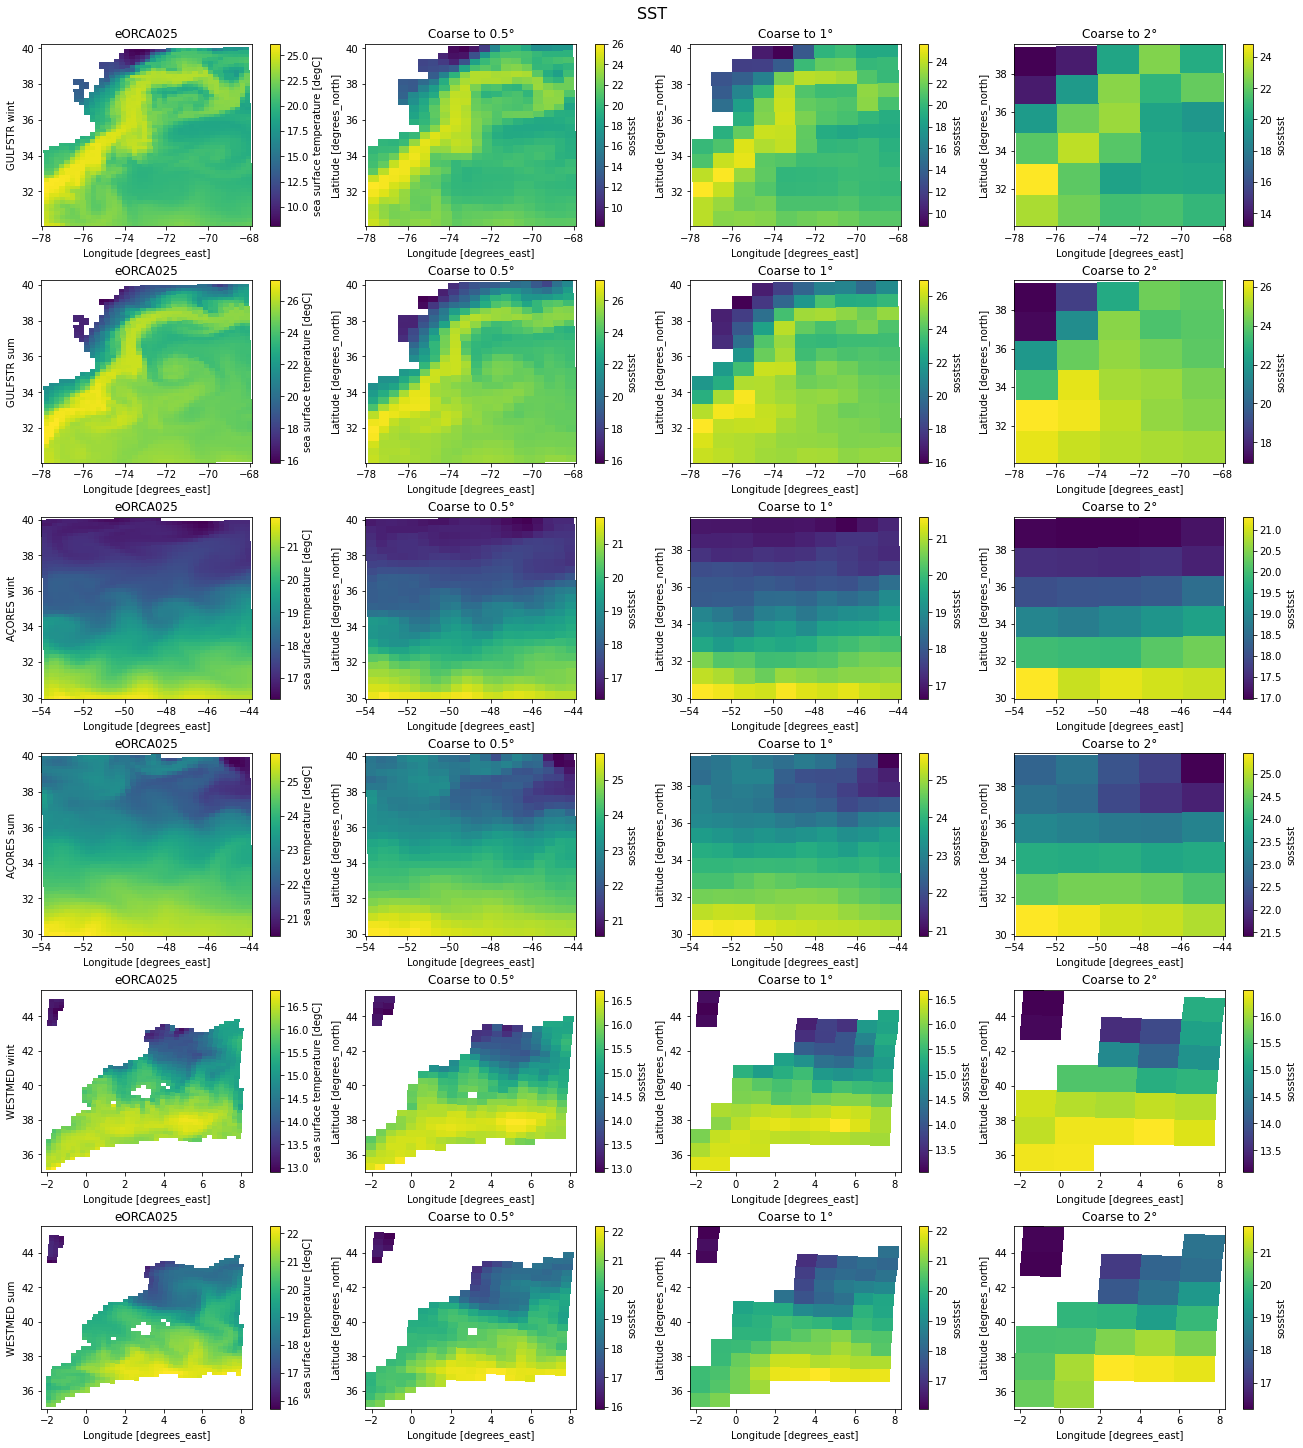

In [125]:
fig, axis = plt.subplots(ncols=4, nrows=6, figsize=(18,20), constrained_layout=True)
quantity='sosstsst'
fig.suptitle('SST', size=16)
for row in range(len(data)) :
    data[row]['LR'].isel(time_counter=-1)[quantity].plot(x='lon', y='lat', ax=axis[row,0])
    axis[row,0].set(title='eORCA025')
    for ifilter in range(len(filters)) :
        col = ifilter+1
        data[row]['LR_mod'][ifilter].isel(time_counter=-1)[quantity].plot(x='lon', y='lat', ax=axis[row,col])
        axis[row,col].set(title=filters[ifilter]['label'])
    axis[row,0].set(ylabel=data[row]['label'])

# Regridding onto HR grid

In [126]:
#regrid_method = "nearest_s2d"
regrid_method = "bilinear"

In [127]:
for i in range(len(data)) :
    data[i]['Regrid_LR_mod'] = [dict({'label' : filters[ifilter]['label']}) for ifilter in range(len(filters))] 

In [178]:
%%time
%%capture --no-display
for i in range(len(data)) :
    ref_data = data[i]['LR']
    out_grid = xr.DataArray(coords={'lon' : ref_data.lon, 'lat' : ref_data.lat, 'x': ref_data.x, 'y': ref_data.y}, \
            dims=['y', 'x'])
    #out_grid = data[i]['LR'].drop(['time_centered', 'depth', 'time_counter', 'e1t', 'e2t', 'e1f', 'e2f', 'e1v', 'e2v', 'e1u', 'e2u', 'nav_lat', 'nav_lon', 'tmask', 'sosstsst', 'sosaline'], error='ignore')
    for ifilter in range(len(filters)) :
        regridder = xe.Regridder(data[i]['LR_mod'][ifilter], out_grid, regrid_method, unmapped_to_nan=True)
        data[i]['Regrid_LR_mod'][ifilter] = regridder(data[i]['LR_mod'][ifilter])
        data[i]['Regrid_LR_mod'][ifilter].coords['e1t'] = ref_data.e1t
        data[i]['Regrid_LR_mod'][ifilter].coords['e2t'] = ref_data.e2t

CPU times: user 1.88 s, sys: 66.4 ms, total: 1.95 s
Wall time: 4.64 s


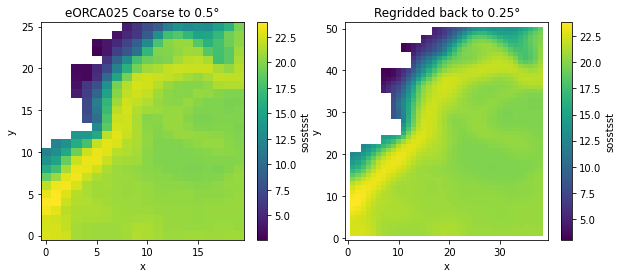

In [180]:
region=0
ifilter=0
fig, axis = plt.subplots(ncols=2, nrows=1, figsize=(10,4))
data[region]['LR_mod'][ifilter].isel(time_counter=0).sosstsst.plot(ax=axis[0])
data[region]['Regrid_LR_mod'][ifilter].isel(time_counter=0).sosstsst.plot(ax=axis[1])
axis[0].set(title='eORCA025 '+filters[ifilter]['label'])
axis[1].set(title='Regridded back to 0.25°')
plt.show()

# Histograms

## General routines

In [181]:
def compute_2D_histogram(dataSet, var1, var2, nb_of_bins, bins=None) :
    if bins is None :
        bins1 = np.linspace(dataSet[var1].min(), dataSet[var1].max(), nb_of_bins)
        bins2 = np.linspace(dataSet[var2].min(), dataSet[var2].max(), nb_of_bins)
    else :
        bins1 = bins[0]; bins2 = bins[1]
    area_weigths = xr.DataArray((dataSet.e1t * dataSet.e2t), dims=['y','x'])
    #area_weigths.fillna(0.)
    normalized_weights = (area_weigths/area_weigths.sum(skipna=True)).fillna(0.)
    hist = histogram(dataSet[var1].fillna(0), dataSet[var2].fillna(0), bins=[bins1, bins2], weights=normalized_weights, density=False)
    norm_hist = (hist/hist.sum(skipna=True)).fillna(0.)
    return norm_hist

In [182]:
min_hist = 1e-5
max_hist = 0.5
log_norm=colors.LogNorm(vmin=min_hist, vmax=max_hist)

# plotting routine
def margin_hist(data, color_index, x_bins, y_bins, ax_histx, ax_histy, ax_big):
    hist_joint = ax_big.pcolormesh(data[x_bins],data[y_bins], data.T, norm=log_norm, cmap=cmaps_list[color_index], shading='auto', alpha=0.75)
    if 'slope' in data.attrs :
        ax_big.plot(data[x_bins], data.attrs['slope']*data[x_bins]+data.attrs['increment'], color=line_colors[color_index])
    
    margin_hist_x = data.sum(dim=y_bins)
    ax_histx.plot(data[x_bins],margin_hist_x, color=line_colors[color_index])
    ax_histx.set(yscale='log', ylim=[min_hist, max_hist])
    ax_histx.tick_params(labelleft=False, labelbottom=False)    
    
    margin_hist_y = data.sum(dim=x_bins)
    ax_histy.plot(margin_hist_y,data[y_bins], color=line_colors[color_index])
    ax_histy.set(xscale='log', xlim=[min_hist, max_hist])
    ax_histy.tick_params(labelleft=False, labelbottom=False)     
    
    return hist_joint

In [183]:
def fit_2D_histogram(hist_ds) :
    x_key = list(hist_ds.coords.keys())[0]
    y_key = list(hist_ds.coords.keys())[1]
    x=hist_ds[x_key]
    y=hist_ds[y_key]
    x_grid, y_grid = np.meshgrid(x, y, indexing='ij')
    x_vec = x_grid.flatten()
    y_vec = y_grid.flatten()
    weights = hist_ds.values.flatten()/np.sum(hist_ds.values)
    fitting_poly = P.polyfit(x_vec,y_vec,1,w=weights,full=True)
    slope = fitting_poly[0][1]
    increment = fitting_poly[0][0]
    resid = fitting_poly[1][0][0]
    mean_x = np.mean(x_grid*hist_ds.values)/np.sum(hist_ds.values)
    mean_y = np.mean(y_grid*hist_ds.values)/np.sum(hist_ds.values)
    return [slope, increment, resid, mean_x, mean_y]

In [184]:
nb_of_bins = 150

In [185]:
# initialize data structure for storing histograms
hists=[dict() for i in range(len(data))]
for i in range(len(data)) :
    hists[i]['LR_mod'] = [dict({'label' : filters[ifilter]['label']}) for ifilter in range(len(filters))] 
    hists[i]['Regrid_LR_mod'] = [dict({'label' : 'Regrid '+filters[ifilter]['label']}) for ifilter in range(len(filters))] 
    hists[i]['LR'] = dict({'label' : 'eORCA025'})

## Histograms of spatial grads

### Compute gradients

In [186]:
def gradx(dataArray, delta_x) :
    return (dataArray.shift(x=-1) - dataArray)/delta_x
def grady(dataArray, delta_y) :
    return (dataArray.shift(y=-1) - dataArray)/delta_y

In [136]:
def diffx(dataArray) :
    return (dataArray.shift(x=-1) - dataArray)
def diffy(dataArray) :
    return (dataArray.shift(y=-1) - dataArray)

In [187]:
%%time
for i in range(len(data)) :
    for ds in [data[i]['LR_mod'][ifilter] for ifilter in range(len(filters))] + [data[i]['LR']] + \
    [data[i]['Regrid_LR_mod'][ifilter] for ifilter in range(len(filters))]:
        ds["alpha"], ds["beta"] = eos_module.alpha_beta(ds["sosaline"], ds["CT"])
        ds['rho_sa_sa'], ds['rho_sa_ct'], ds['rho_ct_ct'] = eos_module.rho_second_derivatives(ds['sosaline'], ds['CT'])
        ds['gradx_temp'] = gradx(ds['CT'], ds['e1t'])
        ds['grady_temp'] = grady(ds['CT'], ds['e2t'])
        ds['gradx_sal'] = gradx(ds['sosaline'], ds['e1t'])
        ds['grady_sal'] = grady(ds['sosaline'], ds['e2t'])
        ds['grad_temp_sqr'] = (ds['gradx_temp']**2 + ds['grady_temp']**2).compute()
        ds['grad_sal_sqr'] = (ds['gradx_sal']**2 + ds['grady_sal']**2).compute()
        ds['grad_temp'] = np.sqrt(ds['grad_temp_sqr'])
        ds['grad_sal'] = np.sqrt(ds['grad_sal_sqr'])
        # ds['alpha_nablaT'] = (ds['alpha']*ds['grad_temp']).compute()
        # ds['beta_nablaS'] = (ds['beta']*ds['grad_sal']).compute()
        # ds['spicyness'] = np.sqrt((ds['alpha']*ds['gradx_temp']+ds['beta']*ds['gradx_sal'])**2+(ds['alpha']*ds['grady_temp']+ds['beta']*ds['grady_sal'])**2)
        # ds['buoyancy'] = np.sqrt((ds['alpha']*ds['gradx_temp']-ds['beta']*ds['gradx_sal'])**2+(ds['alpha']*ds['grady_temp']-ds['beta']*ds['grady_sal'])**2)
        ds['temp_second_deriv'] = np.abs((ds['rho_ct_ct']*ds['grad_temp_sqr']).compute())
        # ds['mixed_second_deriv'] = (ds['rho_sa_ct']*ds['grad_temp']*ds['grad_sal']).compute()
        ds['sal_second_deriv'] = np.abs((ds['rho_sa_sa']*ds['grad_sal_sqr']).compute())
        # ds['total_second_deriv'] = ds['temp_second_deriv']+2.*ds['mixed_second_deriv']+ds['sal_second_deriv']

CPU times: user 38.8 s, sys: 302 ms, total: 39.2 s
Wall time: 50.1 s


### Temperature

In [188]:
%%time
name_hist = 'hist_temp_grad_2D'
x = 'gradx_temp'
y = 'grady_temp'
for i in range(len(data)) :
    # reference histogram
    ref_case = 0
    ref_hist = compute_2D_histogram(data[i]['LR'], x, y, nb_of_bins).compute()
    bins = [ref_hist[x+'_bin'].values, ref_hist[y+'_bin'].values]
    for dataKey in ['LR'] :
        hists[i][dataKey][name_hist] = compute_2D_histogram(data[i][dataKey], x, y, nb_of_bins, bins=bins).compute()
    for filtered_quantity in ['LR_mod', 'Regrid_LR_mod'] :
        for ifilter in range(len(filters)) :
            hists[i][filtered_quantity][ifilter][name_hist] = compute_2D_histogram(data[i][filtered_quantity][ifilter], \
                                                                           x, y, nb_of_bins, bins=bins).compute()

CPU times: user 2.01 s, sys: 67.2 ms, total: 2.07 s
Wall time: 5.6 s


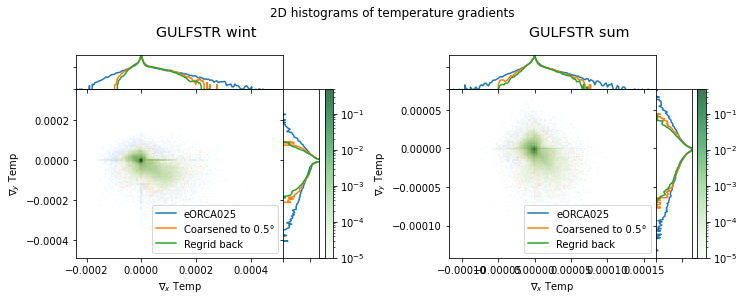

In [189]:
name_hist = 'hist_temp_grad_2D'
x = 'gradx_temp_bin'
y = 'grady_temp_bin'

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 4))
fig.suptitle('2D histograms of temperature gradients')
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = fig.subfigures(1, 2, wspace=0.07)
for a in axs:
    for spine in ['top', 'right', 'bottom', 'left'] :
        a.spines[spine].set_visible(False)
    a.get_xaxis().set_ticks([]); a.get_yaxis().set_ticks([])    
gs = GridSpec(2, 3, width_ratios=[10, 2.0, 1], height_ratios=[2.0, 10], wspace=0, hspace=0)
for subfig_index, region in enumerate([0,1]) :
    subfigs[subfig_index].suptitle(data[region]['label'], fontsize='x-large')
    sel_data0 = hists[region]['LR'][name_hist]
    sel_data1 = hists[region]['LR_mod'][0][name_hist]
    sel_data2 = hists[region]['Regrid_LR_mod'][0][name_hist]
    big_ax = subfigs[subfig_index].add_subplot(gs[1,0]) # bottom left
    top_ax = subfigs[subfig_index].add_subplot(gs[0,0], sharex=big_ax) # top left
    right_ax = subfigs[subfig_index].add_subplot(gs[1,1], sharey=big_ax) # bottom center
    cbar_ax = subfigs[subfig_index].add_subplot(gs[1,2]) # bottom right
    cbar_ax.set(xticks=[], yticks=[])

    margin_hist(sel_data0, 0, x, y, top_ax, right_ax, big_ax)
    hist_joint = margin_hist(sel_data1, 1, x, y, top_ax, right_ax, big_ax)
    hist_joint = margin_hist(sel_data2, 2, x, y, top_ax, right_ax, big_ax)
    big_ax.set(xlabel=r'$\nabla_x$ Temp', ylabel=r'$\nabla_y$ Temp')
    big_ax.legend(handles=top_ax.lines, labels=['eORCA025', 'Coarsened to 0.5°', 'Regrid back'], loc='lower right')

    subfigs[subfig_index].colorbar(hist_joint, ax=cbar_ax, anchor=(0.0, 0.0),pad=0.25,fraction=1.)

plt.show()

### Salinity

In [191]:
%%time
name_hist = 'hist_sal_grad_2D'
x = 'gradx_sal'
y = 'grady_sal'
for i in range(len(data)) :
    # reference histogram
    ref_case = 0
    ref_hist = compute_2D_histogram(data[i]['LR'], x, y, nb_of_bins).compute()
    bins = [ref_hist[x+'_bin'].values, ref_hist[y+'_bin'].values]
    for dataKey in ['LR'] :
        hists[i][dataKey][name_hist] = compute_2D_histogram(data[i][dataKey], x, y, nb_of_bins, bins=bins).compute()
    for filtered_quantity in ['LR_mod', 'Regrid_LR_mod'] :
        for ifilter in range(len(filters)) :
            hists[i][filtered_quantity][ifilter][name_hist] = compute_2D_histogram(data[i][filtered_quantity][ifilter], \
                                                                           x, y, nb_of_bins, bins=bins).compute()

CPU times: user 2.56 s, sys: 88.2 ms, total: 2.64 s
Wall time: 8.89 s


### Joint temperature and salinity

In [192]:
%%time
name_hist = 'hist_temp_sal_sqr'
# x = 'temp_second_deriv'
# y = 'sal_second_deriv'
x='grad_temp_sqr'
y='grad_sal_sqr'

for i in range(len(data)) :
    # reference histogram
    ref_case = 0
    ref_hist = compute_2D_histogram(data[i]['LR'], x, y, nb_of_bins).compute()
    bins = [ref_hist[x+'_bin'].values, ref_hist[y+'_bin'].values]
    for dataKey in ['LR'] :
        hists[i][dataKey][name_hist] = compute_2D_histogram(data[i][dataKey], x, y, nb_of_bins, bins=bins).compute()
    for filtered_quantity in ['LR_mod', 'Regrid_LR_mod'] :
        for ifilter in range(len(filters)) :
            hists[i][filtered_quantity][ifilter][name_hist] = compute_2D_histogram(data[i][filtered_quantity][ifilter].chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}), \
                                                                           x, y, nb_of_bins, bins=bins).compute()

CPU times: user 2.92 s, sys: 95.6 ms, total: 3.02 s
Wall time: 7.26 s


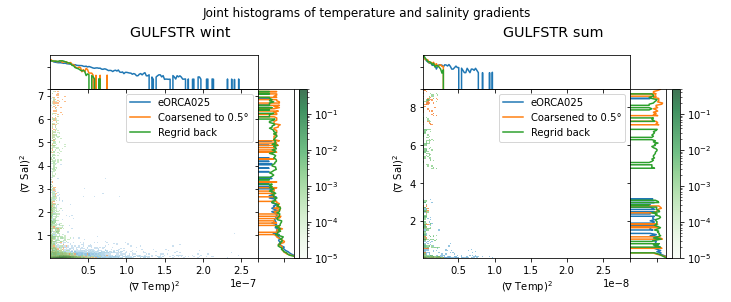

In [194]:
name_hist = 'hist_temp_sal_sqr'
x = 'grad_temp_sqr_bin'
y = 'grad_sal_sqr_bin'

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 4))
fig.suptitle('Joint histograms of temperature and salinity gradients')
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = fig.subfigures(1, 2, wspace=0.07)
for a in axs:
    for spine in ['top', 'right', 'bottom', 'left'] :
        a.spines[spine].set_visible(False)
    a.get_xaxis().set_ticks([]); a.get_yaxis().set_ticks([])    
gs = GridSpec(2, 3, width_ratios=[10, 2.0, 1], height_ratios=[2.0, 10], wspace=0, hspace=0)
for subfig_index, region in enumerate([0,1]) :
    subfigs[subfig_index].suptitle(data[region]['label'], fontsize='x-large')
    sel_data0 = hists[region]['LR'][name_hist]
    sel_data1 = hists[region]['LR_mod'][0][name_hist]
    sel_data2 = hists[region]['Regrid_LR_mod'][0][name_hist]
    big_ax = subfigs[subfig_index].add_subplot(gs[1,0]) # bottom left
    top_ax = subfigs[subfig_index].add_subplot(gs[0,0], sharex=big_ax) # top left
    right_ax = subfigs[subfig_index].add_subplot(gs[1,1], sharey=big_ax) # bottom center
    cbar_ax = subfigs[subfig_index].add_subplot(gs[1,2]) # bottom right
    cbar_ax.set(xticks=[], yticks=[])

    margin_hist(sel_data0, 0, x, y, top_ax, right_ax, big_ax)
    hist_joint = margin_hist(sel_data1, 1, x, y, top_ax, right_ax, big_ax)
    hist_joint = margin_hist(sel_data2, 2, x, y, top_ax, right_ax, big_ax)
    big_ax.set(xlabel=r'($\nabla$ Temp)$^2$', ylabel=r'($\nabla$ Sal)$^2$')
    big_ax.legend(handles=top_ax.lines, labels=['eORCA025', 'Coarsened to 0.5°', 'Regrid back'], loc='upper right')

    subfigs[subfig_index].colorbar(hist_joint, ax=cbar_ax, anchor=(0.0, 0.0),pad=0.25,fraction=1.)

plt.show()

# Distances between histograms

## KL divergence

Kullback-Leibler (KL) divergence (or relative entropy) 
$$ D_{KL} (P || Q) = \sum_i P(i) \log\frac{P(i)}{Q(i)} $$
a measure of how one probability distribution $Q$ is different from a second, reference probability distribution $P$ (information gain of $P$ in comparison to $Q$). In other words, it is the amount of information lost when $Q$ is used to approximate $P$.

In [195]:
def D_KL(hist_P, hist_Q) :
    masked_P = np.where(hist_P >0, hist_P, np.NaN)
    masked_Q = np.where(hist_Q >0, hist_Q, np.NaN)
    return np.nansum(masked_P*(np.log(masked_P/masked_Q)))

Symmertrized KL divergence (Jeffreys divergence):
$$ D_{sym} (P || Q) = D_{KL} (P || Q) + D_{KL} (Q || P) $$

In [196]:
def D_sym(hist_P, hist_Q) :
    return D_KL(hist_P, hist_Q)+D_KL(hist_Q, hist_P)

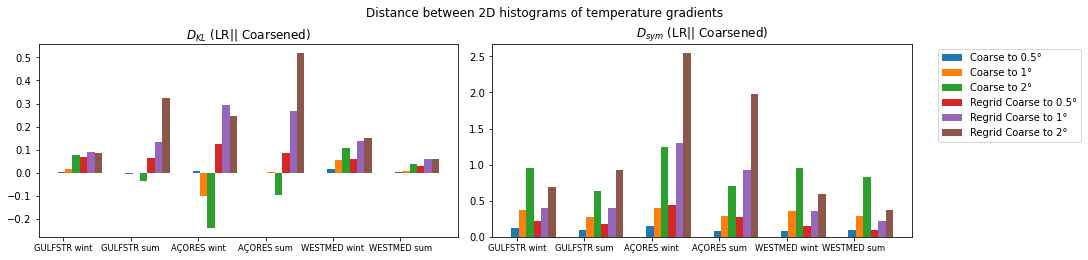

In [205]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(15, 3.5))
fig.suptitle('Distance between 2D histograms of temperature gradients')
name_hist = 'hist_temp_grad_2D'
ref_dataKey = 'LR'
x = np.arange(len(data))
bar_width = 0.11
#ax[0].bar(x, [D_KL(hists[region][ref_dataKey][name_hist], hists[region]['HR'][name_hist]) for region in range(len(data))], width=bar_width)
#ax[1].bar(x, [D_sym(hists[region][ref_dataKey][name_hist], hists[region]['HR'][name_hist]) for region in range(len(data))], width=bar_width, label='HR no filter')
for ifilter in range(len(filters)) :
    ax[0].bar(x+(ifilter+1)*bar_width, [D_KL(hists[region][ref_dataKey][name_hist], hists[region]['LR_mod'][ifilter][name_hist]) for region in range(len(data))], width=bar_width)
    ax[1].bar(x+(ifilter+1)*bar_width, [D_sym(hists[region][ref_dataKey][name_hist], hists[region]['LR_mod'][ifilter][name_hist]) for region in range(len(data))], \
              width=bar_width, label=filters[ifilter]['label'])
    
for ifilter in range(len(filters)) :
    ax[0].bar(x+(ifilter+4)*bar_width, [D_KL(hists[region][ref_dataKey][name_hist], hists[region]['Regrid_LR_mod'][ifilter][name_hist]) for region in range(len(data))], width=bar_width)
    ax[1].bar(x+(ifilter+4)*bar_width, [D_sym(hists[region][ref_dataKey][name_hist], hists[region]['Regrid_LR_mod'][ifilter][name_hist]) for region in range(len(data))], \
              width=bar_width, label='Regrid '+filters[ifilter]['label'])
ax[0].set_xticks(x + 1.25*bar_width)
ax[0].set_xticklabels([data[region]['label'] for region in range(len(data))],fontsize=10)
ax[0].xaxis.set_tick_params(labelsize='small')
ax[0].set(title=r'$D_{KL}$ ('+ ref_dataKey +'|| Coarsened)')
ax[0].set(yscale='linear')
    
ax[1].set_xticks(x + 1.25*bar_width)
ax[1].set_xticklabels([data[region]['label'] for region in range(len(data))])
ax[1].xaxis.set_tick_params(labelsize='small')
ax[1].set(title=r'$D_{sym}$ ('+ ref_dataKey +'|| Coarsened)')
ax[1].set(yscale='linear')

ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

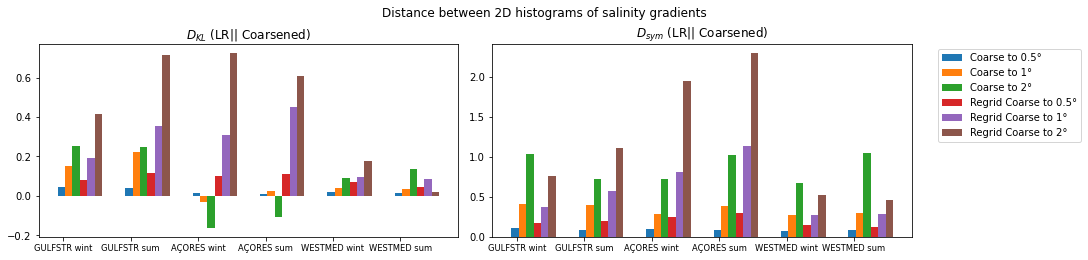

In [206]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(15, 3.5))
fig.suptitle('Distance between 2D histograms of salinity gradients')
name_hist = 'hist_sal_grad_2D'
ref_dataKey = 'LR'
x = np.arange(len(data))
bar_width = 0.11
#ax[0].bar(x, [D_KL(hists[region][ref_dataKey][name_hist], hists[region]['HR'][name_hist]) for region in range(len(data))], width=bar_width)
#ax[1].bar(x, [D_sym(hists[region][ref_dataKey][name_hist], hists[region]['HR'][name_hist]) for region in range(len(data))], width=bar_width, label='HR no filter')
for ifilter in range(len(filters)) :
    ax[0].bar(x+(ifilter+1)*bar_width, [D_KL(hists[region][ref_dataKey][name_hist], hists[region]['LR_mod'][ifilter][name_hist]) for region in range(len(data))], width=bar_width)
    ax[1].bar(x+(ifilter+1)*bar_width, [D_sym(hists[region][ref_dataKey][name_hist], hists[region]['LR_mod'][ifilter][name_hist]) for region in range(len(data))], \
              width=bar_width, label=filters[ifilter]['label'])
    
for ifilter in range(len(filters)) :
    ax[0].bar(x+(ifilter+4)*bar_width, [D_KL(hists[region][ref_dataKey][name_hist], hists[region]['Regrid_LR_mod'][ifilter][name_hist]) for region in range(len(data))], width=bar_width)
    ax[1].bar(x+(ifilter+4)*bar_width, [D_sym(hists[region][ref_dataKey][name_hist], hists[region]['Regrid_LR_mod'][ifilter][name_hist]) for region in range(len(data))], \
              width=bar_width, label='Regrid '+filters[ifilter]['label'])
ax[0].set_xticks(x + 1.25*bar_width)
ax[0].set_xticklabels([data[region]['label'] for region in range(len(data))],fontsize=10)
ax[0].xaxis.set_tick_params(labelsize='small')
ax[0].set(title=r'$D_{KL}$ ('+ ref_dataKey +'|| Coarsened)')
ax[0].set(yscale='linear')
    
ax[1].set_xticks(x + 1.25*bar_width)
ax[1].set_xticklabels([data[region]['label'] for region in range(len(data))])
ax[1].xaxis.set_tick_params(labelsize='small')
ax[1].set(title=r'$D_{sym}$ ('+ ref_dataKey +'|| Coarsened)')
ax[1].set(yscale='linear')

ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## B-distrance

- Bhattacharyya distance (to estimate overlap between two distributions):
$$ D_B(P,Q) = -\log[BC(P,Q)] $$
$$ BC(P,Q) = \sum_i \sqrt{P(i) Q(i)} $$
- Helliger distance:
$$D_H (P,Q) = \sqrt{1-BC(P,Q)}$$ 
is limited $0<D_H (P,Q)<1$ 

In [163]:
def BC(hist_P, hist_Q) :
    return np.nansum(np.sqrt(hist_P*hist_Q))

def D_H(hist_P, hist_Q) :
    return np.sqrt(1.-BC(hist_P,hist_Q))

def D_B(hist_P, hist_Q) :
    BC_val = BC(hist_P,hist_Q)
    if (BC_val > 0) :
        return -np.log(BC_val)
    else:
        return 0.

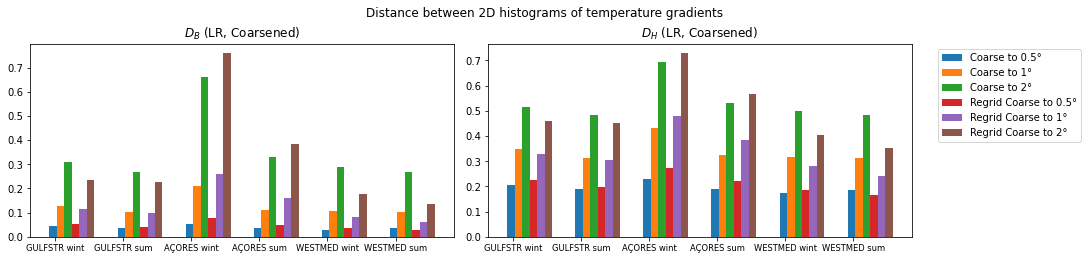

In [207]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(15, 3.5))
fig.suptitle('Distance between 2D histograms of temperature gradients')
name_hist = 'hist_temp_grad_2D'
ref_dataKey = 'LR'
x = np.arange(len(data))
bar_width = 0.11
#ax[0].bar(x, [D_B(hists[region][ref_dataKey][name_hist], hists[region]['HR'][name_hist]) for region in range(len(data))], width=bar_width)
#ax[1].bar(x, [D_H(hists[region][ref_dataKey][name_hist], hists[region]['HR'][name_hist]) for region in range(len(data))], width=bar_width, label='HR no filter')
for ifilter in range(len(filters)) :
    ax[0].bar(x+(ifilter+1)*bar_width, [D_B(hists[region][ref_dataKey][name_hist], hists[region]['LR_mod'][ifilter][name_hist]) for region in range(len(data))], width=bar_width)
    ax[1].bar(x+(ifilter+1)*bar_width, [D_H(hists[region][ref_dataKey][name_hist], hists[region]['LR_mod'][ifilter][name_hist]) for region in range(len(data))], width=bar_width, \
              label=filters[ifilter]['label'])
    
for ifilter in range(len(filters)) :
    ax[0].bar(x+(ifilter+4)*bar_width, [D_B(hists[region][ref_dataKey][name_hist], hists[region]['Regrid_LR_mod'][ifilter][name_hist]) for region in range(len(data))], width=bar_width)
    ax[1].bar(x+(ifilter+4)*bar_width, [D_H(hists[region][ref_dataKey][name_hist], hists[region]['Regrid_LR_mod'][ifilter][name_hist]) for region in range(len(data))], width=bar_width, \
              label='Regrid '+filters[ifilter]['label'])
ax[0].set_xticks(x + 1.25*bar_width)
ax[0].set_xticklabels([data[region]['label'] for region in range(len(data))],fontsize=10)
ax[0].xaxis.set_tick_params(labelsize='small')
ax[0].set(title=r'$D_B$ ('+ ref_dataKey +', Coarsened)')
ax[0].set(yscale='linear')
    
ax[1].set_xticks(x + 1.25*bar_width)
ax[1].set_xticklabels([data[region]['label'] for region in range(len(data))])
ax[1].xaxis.set_tick_params(labelsize='small')
ax[1].set(title=r'$D_H$ ('+ ref_dataKey +', Coarsened)')
ax[1].set(yscale='linear')

ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

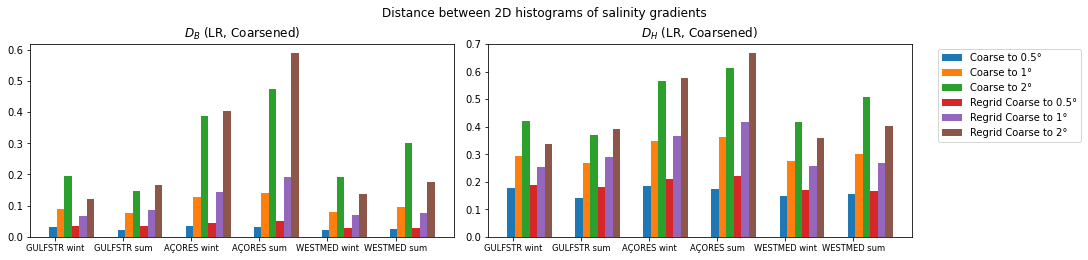

In [208]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(15, 3.5))
fig.suptitle('Distance between 2D histograms of salinity gradients')
name_hist = 'hist_sal_grad_2D'
ref_dataKey = 'LR'
x = np.arange(len(data))
bar_width = 0.11
#ax[0].bar(x, [D_B(hists[region][ref_dataKey][name_hist], hists[region]['HR'][name_hist]) for region in range(len(data))], width=bar_width)
#ax[1].bar(x, [D_H(hists[region][ref_dataKey][name_hist], hists[region]['HR'][name_hist]) for region in range(len(data))], width=bar_width, label='HR no filter')
for ifilter in range(len(filters)) :
    ax[0].bar(x+(ifilter+1)*bar_width, [D_B(hists[region][ref_dataKey][name_hist], hists[region]['LR_mod'][ifilter][name_hist]) for region in range(len(data))], width=bar_width)
    ax[1].bar(x+(ifilter+1)*bar_width, [D_H(hists[region][ref_dataKey][name_hist], hists[region]['LR_mod'][ifilter][name_hist]) for region in range(len(data))], width=bar_width, \
              label=filters[ifilter]['label'])
    
for ifilter in range(len(filters)) :
    ax[0].bar(x+(ifilter+4)*bar_width, [D_B(hists[region][ref_dataKey][name_hist], hists[region]['Regrid_LR_mod'][ifilter][name_hist]) for region in range(len(data))], width=bar_width)
    ax[1].bar(x+(ifilter+4)*bar_width, [D_H(hists[region][ref_dataKey][name_hist], hists[region]['Regrid_LR_mod'][ifilter][name_hist]) for region in range(len(data))], width=bar_width, \
              label='Regrid '+filters[ifilter]['label'])
ax[0].set_xticks(x + 1.25*bar_width)
ax[0].set_xticklabels([data[region]['label'] for region in range(len(data))],fontsize=10)
ax[0].xaxis.set_tick_params(labelsize='small')
ax[0].set(title=r'$D_B$ ('+ ref_dataKey +', Coarsened)')
ax[0].set(yscale='linear')
    
ax[1].set_xticks(x + 1.25*bar_width)
ax[1].set_xticklabels([data[region]['label'] for region in range(len(data))])
ax[1].xaxis.set_tick_params(labelsize='small')
ax[1].set(title=r'$D_H$ ('+ ref_dataKey +', Coarsened)')
ax[1].set(yscale='linear')

ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

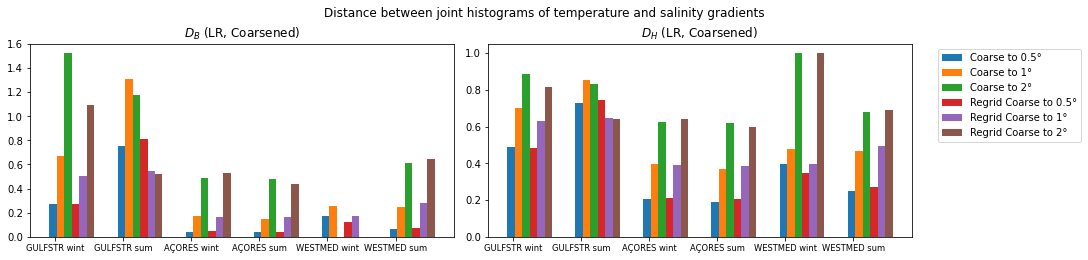

In [209]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(15, 3.5))
fig.suptitle('Distance between joint histograms of temperature and salinity gradients')
name_hist = 'hist_temp_sal_sqr'
ref_dataKey = 'LR'
x = np.arange(len(data))
bar_width = 0.11
#ax[0].bar(x, [D_B(hists[region][ref_dataKey][name_hist], hists[region]['HR'][name_hist]) for region in range(len(data))], width=bar_width)
#ax[1].bar(x, [D_H(hists[region][ref_dataKey][name_hist], hists[region]['HR'][name_hist]) for region in range(len(data))], width=bar_width, label='HR no filter')
for ifilter in range(len(filters)) :
    ax[0].bar(x+(ifilter+1)*bar_width, [D_B(hists[region][ref_dataKey][name_hist], hists[region]['LR_mod'][ifilter][name_hist]) for region in range(len(data))], width=bar_width)
    ax[1].bar(x+(ifilter+1)*bar_width, [D_H(hists[region][ref_dataKey][name_hist], hists[region]['LR_mod'][ifilter][name_hist]) for region in range(len(data))], width=bar_width, \
              label=filters[ifilter]['label'])
for ifilter in range(len(filters)) :
    ax[0].bar(x+(ifilter+4)*bar_width, [D_B(hists[region][ref_dataKey][name_hist], hists[region]['Regrid_LR_mod'][ifilter][name_hist]) for region in range(len(data))], width=bar_width)
    ax[1].bar(x+(ifilter+4)*bar_width, [D_H(hists[region][ref_dataKey][name_hist], hists[region]['Regrid_LR_mod'][ifilter][name_hist]) for region in range(len(data))], width=bar_width, \
              label='Regrid '+filters[ifilter]['label'])
ax[0].set_xticks(x + 1.25*bar_width)
ax[0].set_xticklabels([data[region]['label'] for region in range(len(data))],fontsize=10)
ax[0].xaxis.set_tick_params(labelsize='small')
ax[0].set(title=r'$D_B$ ('+ ref_dataKey +', Coarsened)')
ax[0].set(yscale='linear')
    
ax[1].set_xticks(x + 1.25*bar_width)
ax[1].set_xticklabels([data[region]['label'] for region in range(len(data))])
ax[1].xaxis.set_tick_params(labelsize='small')
ax[1].set(title=r'$D_H$ ('+ ref_dataKey +', Coarsened)')
ax[1].set(yscale='linear')

ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [68]:
#data[2]['LR']['grad_sal_sqr'].isel(time_counter=0).plot()

In [69]:
#hists[2]['LR']['hist_temp_sal_sqr']